In [1]:
#import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random


Using TensorFlow backend.


In [2]:
#prepare dataset
datadir = 'dataset1'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
#for index,item in data.iterrows():
 #   print(data)
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
print (data.shape)
pd.set_option('display.max_colwidth', -1)
data.head()

(7027, 7)


/home/arsalan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


,center,left,right,steering,throttle,reverse,speed
0,/home/arsalan/Desktop/dataset/IMG/center_2020_07_25_14_27_15_263.jpg,/home/arsalan/Desktop/dataset/IMG/left_2020_07_25_14_27_15_263.jpg,/home/arsalan/Desktop/dataset/IMG/right_2020_07_25_14_27_15_263.jpg,0.0,0.0,0.0,0.000078
1,/home/arsalan/Desktop/dataset/IMG/center_2020_07_25_14_27_15_383.jpg,/home/arsalan/Desktop/dataset/IMG/left_2020_07_25_14_27_15_383.jpg,/home/arsalan/Desktop/dataset/IMG/right_2020_07_25_14_27_15_383.jpg,0.0,0.0,0.0,0.000078
2,/home/arsalan/Desktop/dataset/IMG/center_2020_07_25_14_27_15_494.jpg,/home/arsalan/Desktop/dataset/IMG/left_2020_07_25_14_27_15_494.jpg,/home/arsalan/Desktop/dataset/IMG/right_2020_07_25_14_27_15_494.jpg,0.0,0.0,0.0,0.000078
3,/home/arsalan/Desktop/dataset/IMG/center_2020_07_25_14_27_15_603.jpg,/home/arsalan/Desktop/dataset/IMG/left_2020_07_25_14_27_15_603.jpg,/home/arsalan/Desktop/dataset/IMG/right_2020_07_25_14_27_15_603.jpg,0.0,0.0,0.0,0.000079
4,/home/arsalan/Desktop/dataset/IMG/center_2020_07_25_14_27_15_714.jpg,/home/arsalan/Desktop/dataset/IMG/left_2020_07_25_14_27_15_714.jpg,/home/arsalan/Desktop/dataset/IMG/right_2020_07_25_14_27_15_714.jpg,0.0,0.0,0.0,0.000078


In [3]:
#cut the head and leave the tail of the path only
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2020_07_25_14_27_15_263.jpg,left_2020_07_25_14_27_15_263.jpg,right_2020_07_25_14_27_15_263.jpg,0.0,0.0,0.0,0.000078
1,center_2020_07_25_14_27_15_383.jpg,left_2020_07_25_14_27_15_383.jpg,right_2020_07_25_14_27_15_383.jpg,0.0,0.0,0.0,0.000078
2,center_2020_07_25_14_27_15_494.jpg,left_2020_07_25_14_27_15_494.jpg,right_2020_07_25_14_27_15_494.jpg,0.0,0.0,0.0,0.000078
3,center_2020_07_25_14_27_15_603.jpg,left_2020_07_25_14_27_15_603.jpg,right_2020_07_25_14_27_15_603.jpg,0.0,0.0,0.0,0.000079
4,center_2020_07_25_14_27_15_714.jpg,left_2020_07_25_14_27_15_714.jpg,right_2020_07_25_14_27_15_714.jpg,0.0,0.0,0.0,0.000078


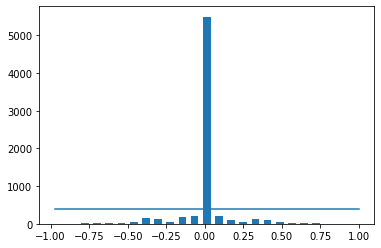

In [4]:
#plot of distribution of steering angles
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


total data: 7027
removed: 5095
remaining: 1932


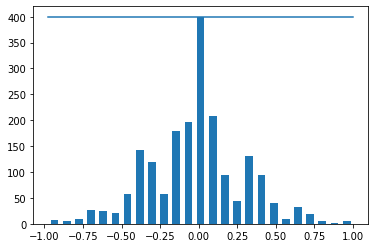

In [6]:
#remove unncessary samples because they can bias your model to predict 0 steering angle only
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [7]:
#check indexes of data yourself
data.iloc[1]

center      center_2020_07_25_14_27_15_603.jpg
left        left_2020_07_25_14_27_15_603.jpg  
right       right_2020_07_25_14_27_15_603.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.88968e-05                       
Name: 3, dtype: object

In [8]:
# append images and steering angles according to their index
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

Training Samples: 4636
Valid Samples: 1160


Text(0.5, 1.0, 'Validation set')

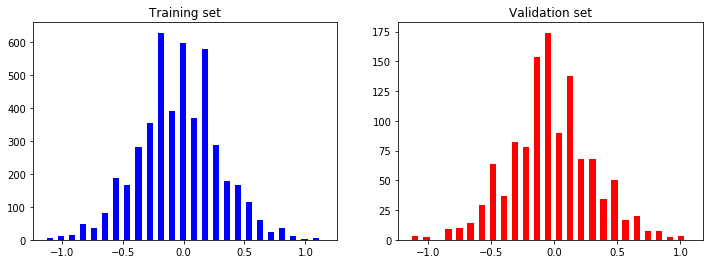

In [9]:
#split into train, validation and test images and corresponding labels
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [10]:
#preprocess all images 
def img_preprocess(img):
    #img= mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img


Text(0.5, 1, 'Preprocessed Image')

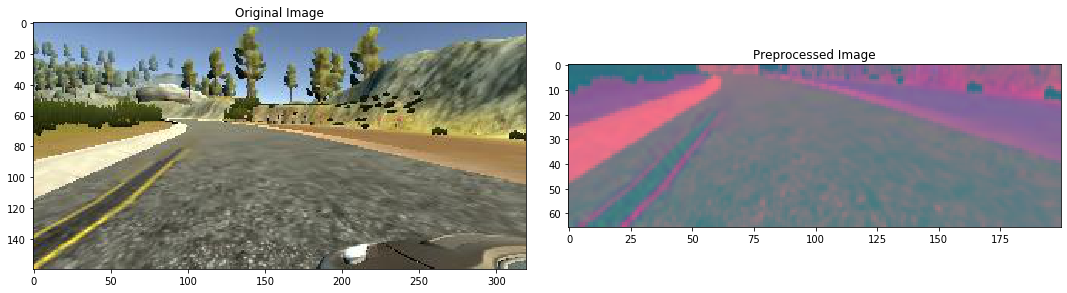

In [11]:
#check one of the preprocessed image
image = image_paths[100]
#print(image.shape)
original_image = mpimg.imread(image)
#print(original_image.shape)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [12]:
#apply zoom using image aug 
def zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    image= zoom.augment_image(image)
    return image

Text(0.5, 1, 'Zoomed Image')

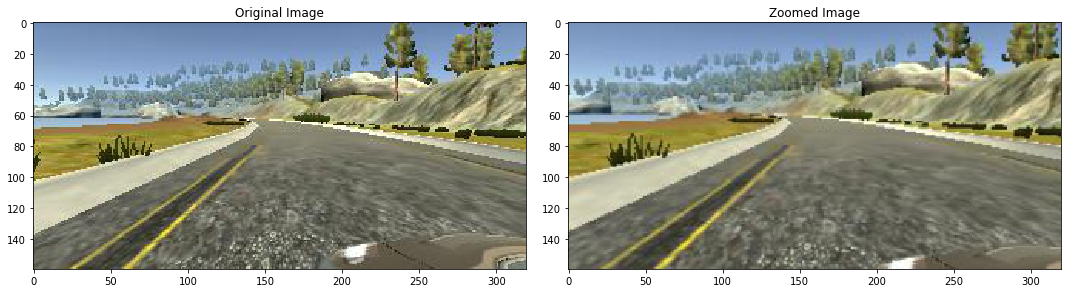

In [13]:
#check it yourself
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')




In [14]:
#apply translation on x and y axis
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1, 'panned Image')

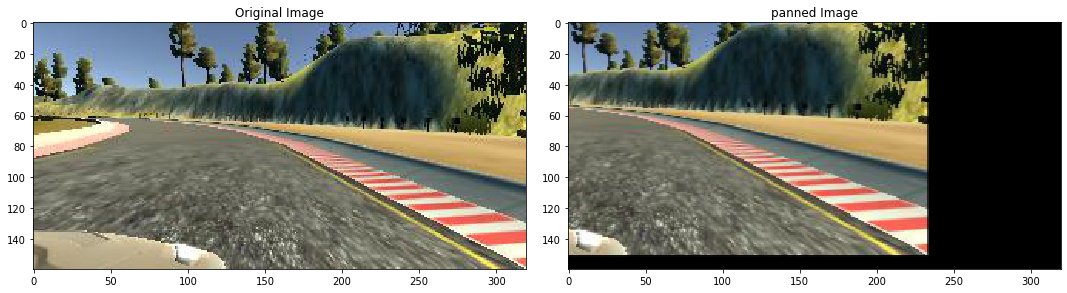

In [15]:
#check it yourself
image = image_paths[random.randint(0,1000)]
original_image= mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('panned Image')

In [16]:
#vary brightness by multiplying pixels intensities 
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2,1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'brighthened_image')

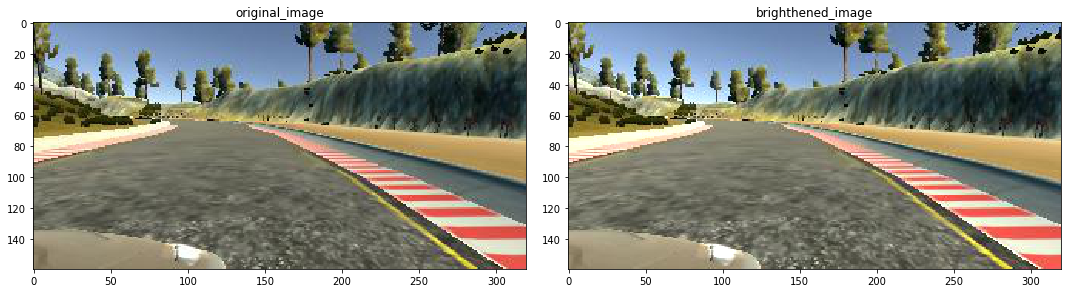

In [17]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brighthened_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('original_image')
axs[1].imshow(brighthened_image)
axs[1].set_title('brighthened_image')


In [18]:
#flip image horizontally for val>0 (selected)
#flipcode = 0: flip vertically
#flipcode < 0: flip vertically and horizontally
#if image is flipped steering angle should flip as well
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = - steering_angle
    return image, steering_angle

-0.018105100000000013 0.018105100000000013


Text(0.5, 1, 'flipped_image')

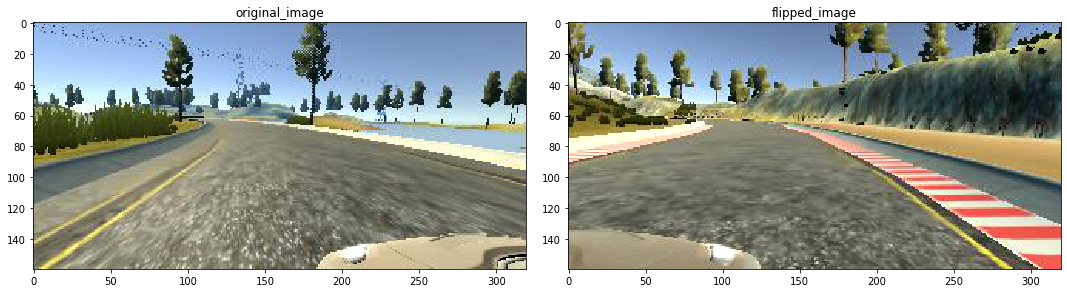

In [19]:
#plot flipped image
random_index = random.randint(0,1000)

image = image_paths[random_index]

steering_angle = steerings[random_index]

original_image = mpimg.imread(image)

flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
print(str(steering_angle), str(flipped_steering_angle))
axs[0].imshow(original_image)
axs[0].set_title('original_image')
axs[1].imshow(brighthened_image)
axs[1].set_title('flipped_image')


In [20]:
#each should have 50% chance of being shown
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.randn()<0.5:
        image=zoom(image)
    if np.random.randn()<0.5:
        image=pan(image)
    if np.random.randn()<0.5:
        image=img_random_brightness(image)
    if np.random.randn()<0.5:
        image, steering_angle=img_random_flip(image,steering_angle)
    return image, steering_angle


0.5042015 -0.5042015
-0.15 0.15
0.08866382 -0.08866382
0.06629634 -0.06629634
0.15 -0.15
-0.42655509999999996 0.42655509999999996
0.2165009 -0.2165009
0.31457090000000004 -0.31457090000000004
1.0798825 -1.0798825
0.22780170000000002 -0.22780170000000002


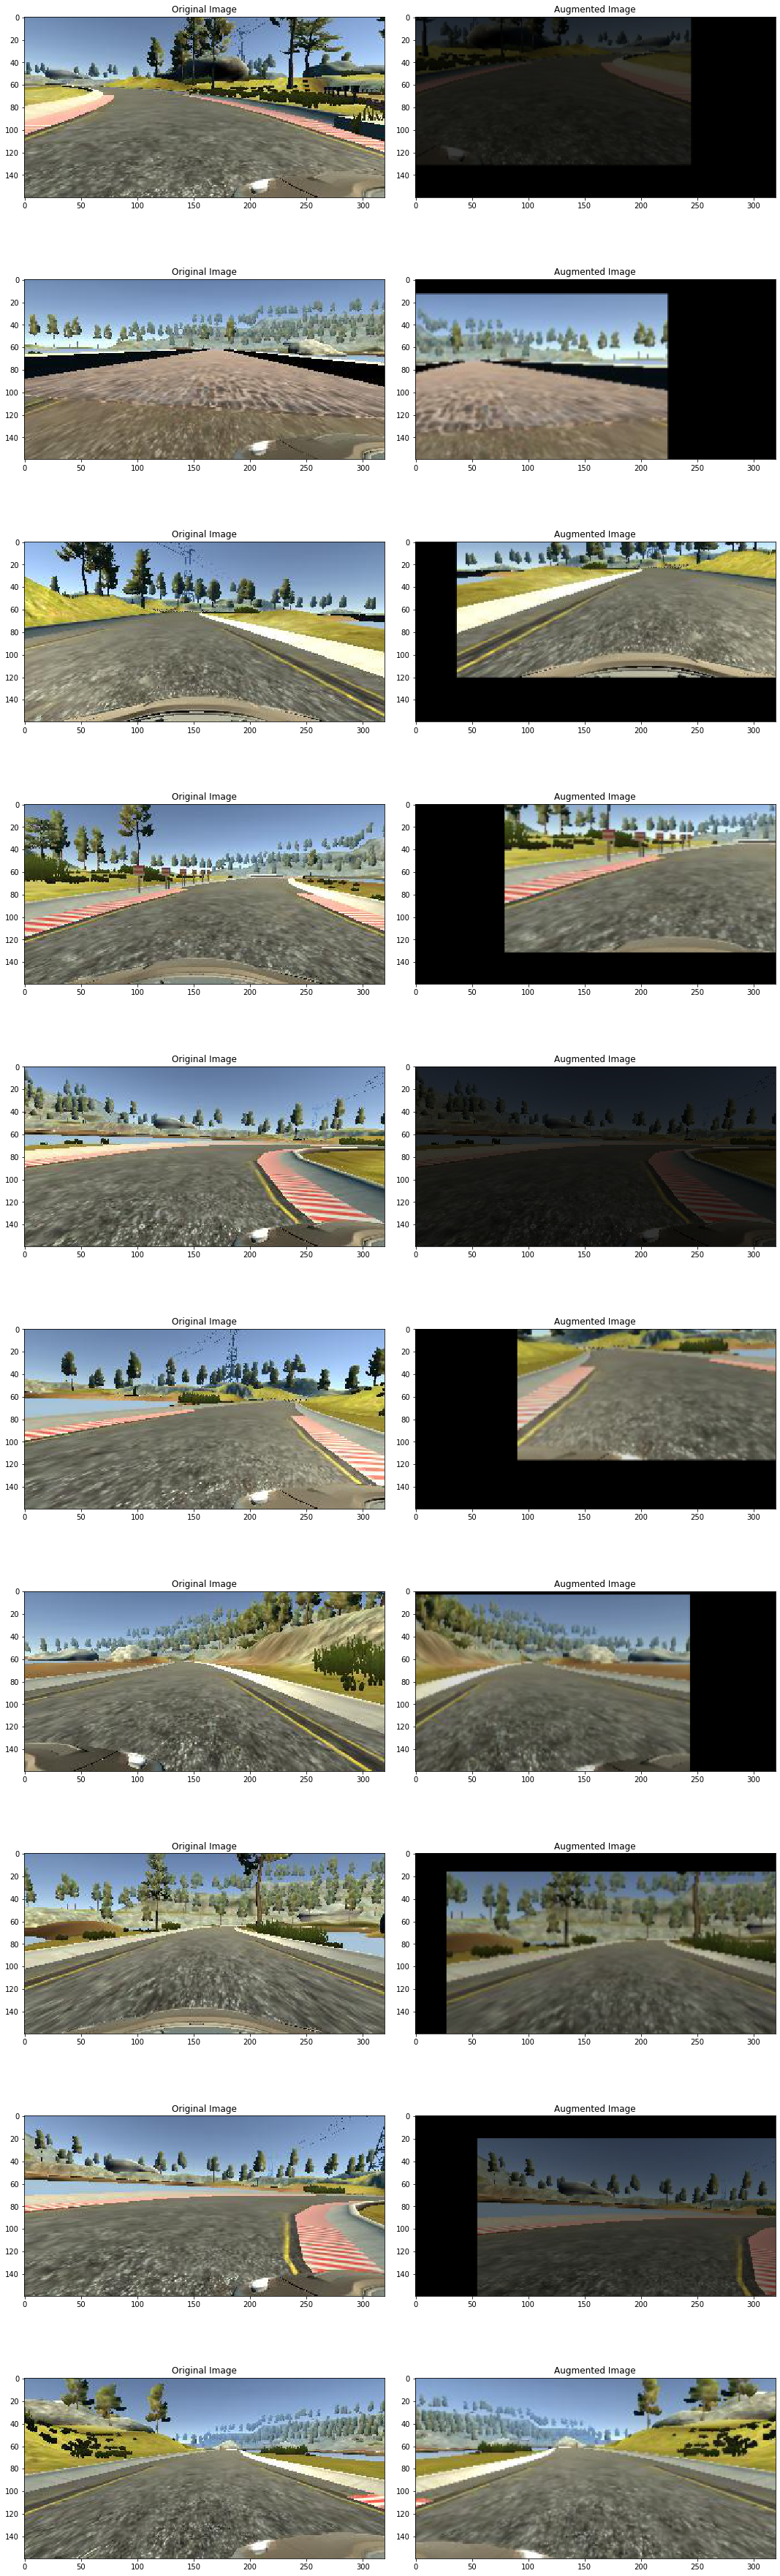

In [21]:
#plot random flipping, zooming, brightening and panning and flipped steering angle
n_cols=2
n_rows=10
fig, axs = plt.subplots(n_rows, 2, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    original_image= mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    print(str(steering),str(-steering))
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [22]:
#create batch generator which returns batches of samples one by one
def batch_generator(image_paths,steering_ang,batch_size, is_training):
    while True:
        batch_images=[]
        batch_steering=[]
        for i in range(batch_size):
            random_index= random.randint(0, len(image_paths) - 1)
            if is_training:
                im,steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im= mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            im = img_preprocess(im)
            batch_images.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_images),np.asarray(batch_steering))

Text(0.5, 1, 'randum_image')

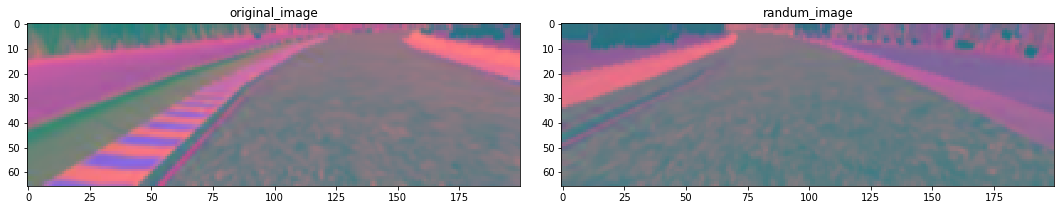

In [23]:
X_train_gen, y_train_gen = next(batch_generator(X_train,y_train,1, 1))
X_val_gen, y_val_gen     = next(batch_generator(X_valid,y_valid,1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('original_image')
axs[1].imshow(X_val_gen[0])
axs[1].set_title('randum_image')

In [24]:
#define nividia model , architecture will be posted
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
  
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [25]:
model = nvidia_model()
model.summary()

/home/arsalan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/arsalan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/arsalan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/home/arsalan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/home/arsalan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Upda

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

In [ ]:
#fit the generator on training and validation data
history = model.fit(batch_generator(X_train,y_train,100, 1),steps_per_epoch=300,
                   epochs=8, validation_data=(batch_generator(X_valid,y_valid,100, 0)),validation_steps=200,
                   shuffle = 1)

In [ ]:
#plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
#save model
model.save('model1.h5')